# Chapter 13 - Inference

In traditional statistics, we test hypothese against a null hypothesis using a Students $t$ test, producing a $p$ value. The Bayesian approach is to construct a posterior distribution for the thing that we care about, and then use that to answer any questions that we have about the underlying quantity.

- Most likely size of the difference
- Credible interval that's likely to contain the true value
- Probability of superiority
- Probability that the difference exceeds some threshold

We'll demonstrate that process using a problem borrowed from a statistcis textbook.

## Improving Reading Ability
- Data is from a PhD dissertation in educational psychology (1987), &c.
- Description:
> An educator condicted an experiment to test whether new directed reading activities in the classroom will help elementary students imprpove some aspects of their reading ability. She arranged for a third grade class od 21 students to follow these activities for an 8-week period. A control classroom of 23 third graders followed the same curriculum without the activities. At the end of the eight weeks,. all students took a Degree of Reading Power (DRP) test, which measures the aspects of reading ability that the treatment is designed to improve.

In [1]:
import pandas as pd
import numpy as np
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt

df = pd.read_csv('./data/drp_scores.csv', skiprows=21, delimiter="\t")
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


In [2]:
# group the data by whether they are in the reatment or control group
grouped = df.groupby('Treatment')
responses = {}

for name, group in grouped:
    responses[name] = group['Response']

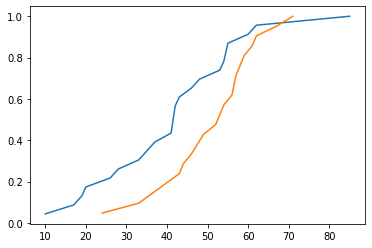

In [3]:
for values in responses.values():
    Cdf.from_seq(values).plot()

So it looks like the treatment group is doing slightly better?

The scores are not entirely normally distributed, but close enough. Let's make the assumption of normality, and assume that each is described by a normal distribution with mean $mu$ and standard deviation $sigma$, and go from there.

## Estimating Parameters
As always, we need a prior distribution for the parameters. Since there are two parameters, it will be a joint distribution. We'll construct it it by choosing marginal distributions for each parameter and computing their outer product.

As a simple starting place: assume that the prior distributions for mu and sigma as uniform.

In [4]:
def make_uniform(qs, name=None, **options):
    """ Make a PMF representing a uniform distribution """
    pmf = Pmf(1, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

# prior distribution for mu
qs = np.linspace(20, 80, num=101)
prior_mu = make_uniform(qs, name='mean')

# prior distribution for sigma
qs = np.linspace(5, 30, num=101)
prior_sigma = make_uniform(qs, name='std')

def make_joint(s1, s2):
    """ 
    Compute the outer product of two Series
    
    First series goes across the columns; second series goes down the rows
    
    Arguments: 
        s1: Series
        s2: Series
        
    Returns:
        DataFrame
    """
    
    X, Y = np.meshgrid(s1, s2)
    return pd.DataFrame(X * Y, columns=s1.index, index=s2.index)

prior = make_joint(prior_mu, prior_sigma)

# start by working with the data from the control group
data = responses['Control']
data.shape

(23,)

## Likelihood

We would like to know the probability of each score given each combination of values for mu and sigma. We'll do that by making a 3d grid of values of mu on the first axis, sigma on the second, and the score on the third

In [5]:
mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
mu_mesh.shape

(101, 101, 23)

In [6]:
# now we can calculate the probabilities of each score
from scipy.stats import norm

densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
densities.shape

(101, 101, 23)

The result is a 3D array. To compute the likelihoods, multiply the densities along axis=2, which is the axis of the data.

In [7]:
likelihood = densities.prod(axis=2)
likelihood.shape

(101, 101)

The result is the probability of the entirety of the set of data, given each combination of mu and sigma.

In [8]:
from utils import normalize

posterior = prior * likelihood
normalize(posterior)
posterior.shape

(101, 101)

The result is a joint distribution representing the joint posterior distribution.

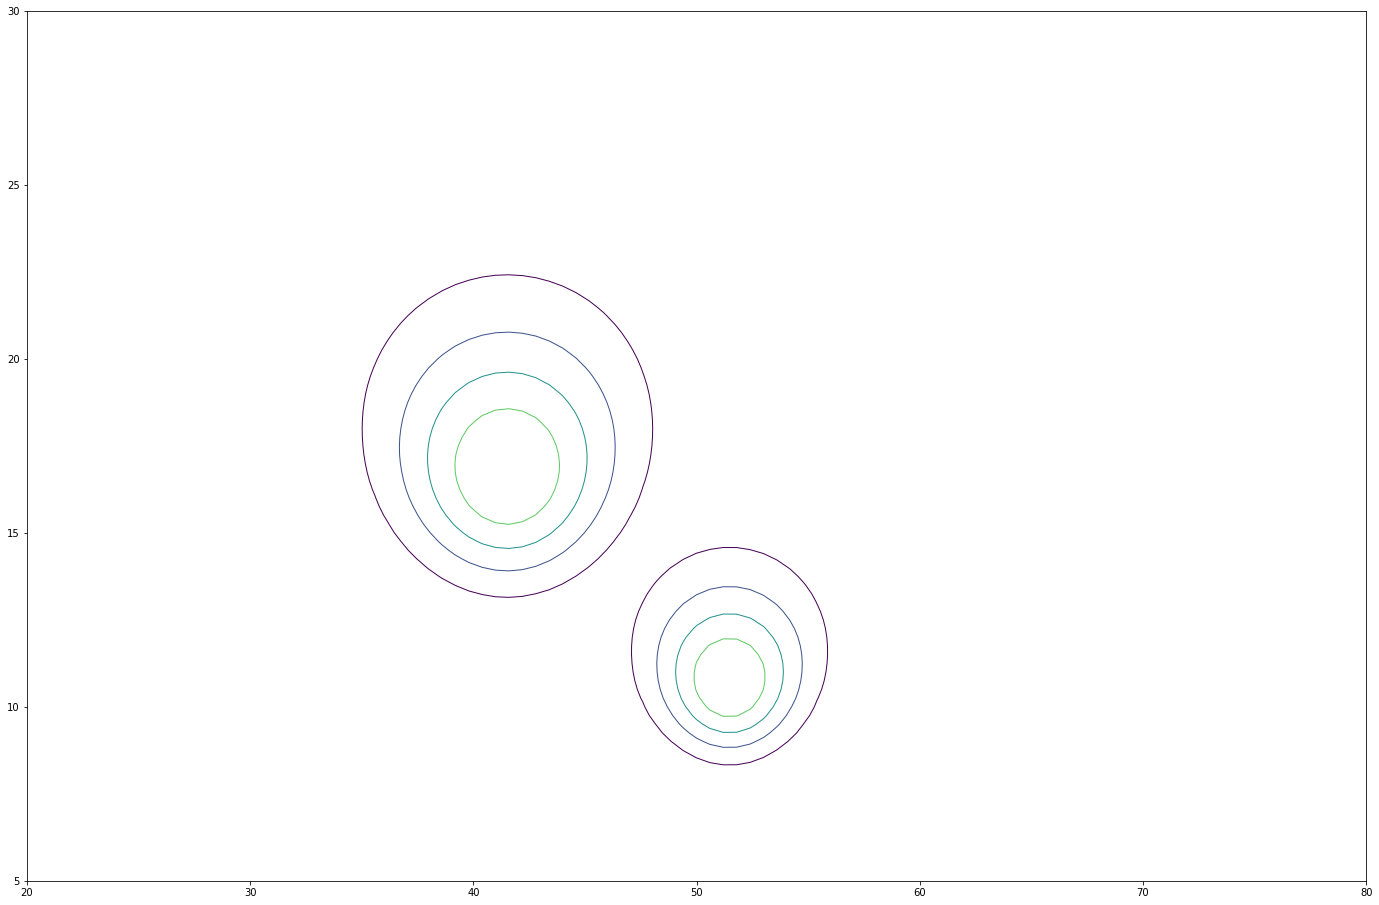

In [9]:
# Let's encapsulate all of this:
def update_norm(prior, data):
    """ Update the prior based on the data """
    mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    
    densities = norm(mu_mesh, sigma_mesh).pdf(data)
    likelihood = densities.prod(axis=2)
    
    posterior = prior * likelihood
    normalize(posterior)
    return posterior

# Now let's update the control and treatment groups:
data = responses['Control']
posterior_control = update_norm(prior, data)

data = responses['Treated']
posterior_treated = update_norm(prior, data)

from utils import plot_contour

fig, ax = plt.subplots()
fig.set_size_inches(24, 16)
plot_contour(posterior_control)
plot_contour(posterior_treated, xlabel="Mean (mu)", ylabel="Std (sigma)")

So from here it looks like the treatment group has a higher mean (bottom axis) and a lower standard deviation (vertical axis)

# Posterior Marginal Distributions
We can extract the marginal distributions of the means:

<AxesSubplot:xlabel='mean'>

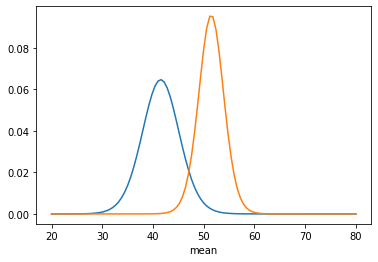

In [10]:
from utils import marginal

pmf_mean_control = marginal(posterior_control, axis=0)
pmf_mean_treated = marginal(posterior_treated, axis=0)

pmf_mean_control.plot()
pmf_mean_treated.plot()

Note that around the bounds that we chose, both distributions are basically zero. This is a good indicator that our bounds were OK.

In [11]:
Pmf.prob_gt(pmf_mean_treated, pmf_mean_control)

0.980479025187326

So it looks like there is a 98\% chance that the mean of the treated group is higher than that of the control group.

## Distribution of Differences

To quantify themagnitude of the differences between the two groups, we can sub_dist to compute the distribution of the difference:

<AxesSubplot:>

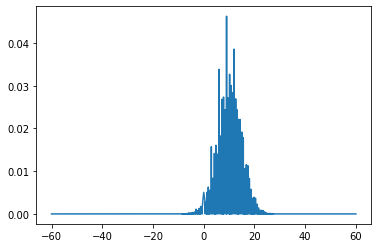

In [12]:
pmf_diff = Pmf.sub_dist(pmf_mean_treated, pmf_mean_control)
pmf_diff.plot()

This is very spiky - we can either plot the CDF or use Kernel Density Estimation to get a smoother estimate

<AxesSubplot:>

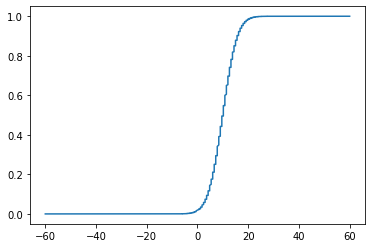

In [13]:
cdf_diff = pmf_diff.make_cdf()
cdf_diff.plot()

<AxesSubplot:>

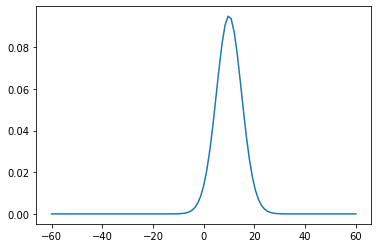

In [14]:
# Or using KDE
from scipy.stats import gaussian_kde

def kde_from_pmf(pmf, n=101):
    kde = gaussian_kde(pmf.qs, weights=pmf.ps)
    qs = np.linspace(pmf.qs.min(), pmf.qs.max(), n)
    ps = kde.evaluate(qs)
    new_pmf = Pmf(ps, qs)
    new_pmf.normalize()
    return new_pmf

kde_diff = kde_from_pmf(pmf_diff)
kde_diff.plot()

In [15]:
pmf_diff.mean()

9.954413088940848

So the mean difference seems to be about 10 points on a test for which the mean is 45 - pretty good!

We can also compute the credible interval for the difference:

In [16]:
pmf_diff.credible_interval(0.9)

array([ 2.4, 17.4])

So again, the interval seems to indicate that the treatment group has a higher score compared to the control group.

## Using Summary Statistics

In this example, the dataset was pretty small, so the actual computations didn't take too long. However, we did end up computing a 3D array, which for a larger dataset could become unfeasible.

We can also run into the problem (with large datasets) that each individual probability is very small (imagine a million datapoints - the probability of any particular one of them is almost surely small!). This can cause problems when using floating-point numbers.

An alternative is to compute some summary statistics, and then compute the probability that we would get those summary statistics! 

For instance, say that we know that $\mu=42$ and $\sigma=17$. Now suppose that we draw a sample from the population with $n=20$, and find that the population mean $m=41$ and the population standard deviation $s=18$. These values are pretty close. To compute the likelihood of getting these values, we are going to rely on some facts:
- Given $\mu$ and $\sigma$, $m\sim N(\mu, \frac{\sigma}{\sqrt{n}})$.
- The distribution of $s$ is more complicated, but if we compute the transform $t = \frac{ns^2}{\sigma^2}$, the distribution of $t$ is chi-squared with parameter $n-1$.
- According to Basu's Theorem, $m$ and $s$ are indenpendent

In [17]:
# population parameters
mu = 42
sigma = 17

# sample parameters
n = 20
m = 41
s = 18

# the sampling distribution of the sample mean
dist_m = norm(mu, sigma / np.sqrt(n))

# calculate the likelihood of the observed sample mean
like1 = dist_m.pdf(m)
like1

0.10137915138497372

Now let's compute the likelihood of the observed value of sigma:

In [18]:
t = n * s ** 2 / sigma ** 2
t

22.422145328719722

In [19]:
from scipy.stats import chi2

dist_s = chi2(n - 1)
like2 = dist_s.pdf(t)
like2

0.04736427909437004

In [20]:
# because m and s are independent:
like = like1 * like2
like

0.004801750420548287

Now we can compute the likelihood of the data for any value of $\mu$ and $\sigma$, which we'll use in the next section to do the update

## Update with Summary Statistics

Let's do the update. First we need to compute the summary statistics for the two populations:

In [21]:
summary = dict()

# the value for each is a tuple (n, m, s) for each group
for name, response in responses.items():
    summary[name] = len(response), response.mean(), response.std()
summary

{'Control': (23, 41.52173913043478, 17.148733229699484),
 'Treated': (21, 51.476190476190474, 11.00735684721381)}

In [22]:
# Let's do the update for the control group:
n, m, s = summary['Control']

mus, sigmas = np.meshgrid(prior.columns, prior.index)
mus.shape

(101, 101)

In [23]:
like1 = norm(mus, sigmas / np.sqrt(n)).pdf(m)
like1.shape

(101, 101)

In [24]:
ts = n * s ** 2 / sigmas ** 2
like2 = chi2(n - 1).pdf(ts)
like2.shape

(101, 101)

In [25]:
posterior_control2 = prior * like1 * like2
normalize(posterior_control2)

0.00030965351017402847

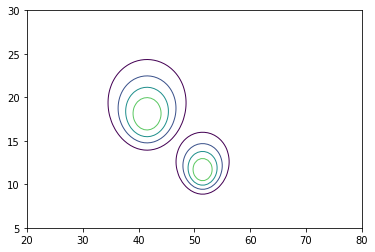

In [26]:
# Now we can put all of this into a function
def update_norm_summary(prior, data):
    """ Update the normal distribution using summary statistics """
    n, m, s = data
    mu_mesh, sigma_mesh = np.meshgrid(prior.columns, prior.index)
    
    like1 = norm(mu_mesh, sigma_mesh / np.sqrt(n)).pdf(m)
    like2 = chi2(n - 1).pdf(n * s ** 2 / sigma_mesh ** 2)
    
    posterior = prior * like1 * like2
    normalize(posterior)
    
    return posterior

data = summary['Treated']
posterior_treated2 = update_norm_summary(prior, data)

plot_contour(posterior_treated2)
plot_contour(posterior_control2)

If everything had worked, then this would have looked similar to the ones that we computed using the entire dataset. However, they are not quite identical:

## Comparing Marginals

<AxesSubplot:xlabel='mean'>

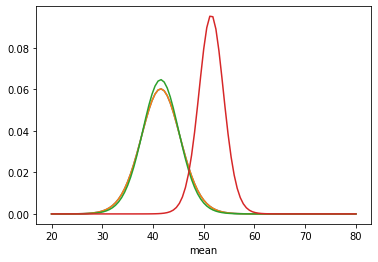

In [27]:
pmf_mean_control_2 = marginal(posterior_control2, 0)
pmf_mean_treated_2 = marginal(posterior_control2, 0)

pmf_mean_control_2.plot()
pmf_mean_treated_2.plot()
pmf_mean_control.plot()
pmf_mean_treated.plot()

Although it is not quite clear just from this, in both cases the plots for the ones using just the summary statistics are slightly fatter and wider than the ones computed using the actual data, as might be expected from the fact that we have thrown away some data (namely, the actual shape of the distribution; we assumed that it was normal).

## Exercises

### Exercise 13-1
> Looking at the posterior joint distribution of $\mu$ and $\sigma$, it looks like the standard deviation of the treated group might be lower; that would suggest that the treatement is more effective for lower-scoring students. However, we should probably check this.
>
> Let's estimate the size of the difference and see whether it might actually be zero,
>
> Extract the marginal posterior distributions of sigma for the two groups. What is the probability that the standard deviation is higher in the control group?
>
> Compute the distribution of the difference in sigma between the two groups. What is the means of the difference? What is the 90\% credible interval?

### Solution 13-1

<AxesSubplot:xlabel='std'>

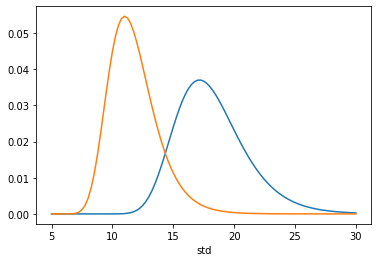

In [31]:
pmf_std_control = marginal(posterior_control, 1)
pmf_std_treated = marginal(posterior_treated, 1)

pmf_std_control.plot()
pmf_std_treated.plot()

In [32]:
Pmf.prob_gt(pmf_std_control, pmf_std_treated)

0.9685103375300469

In [36]:
pmf_diff2 = Pmf.sub_dist(pmf_std_control, pmf_std_treated)
pmf_diff2.mean()

6.41717132817218

<AxesSubplot:>

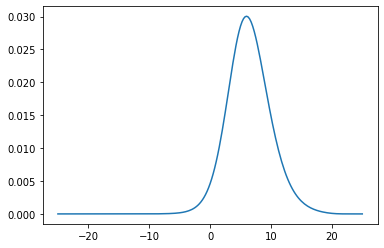

In [38]:
pmf_diff2.credible_interval(0.9)
pmf_diff2.plot()

### Exercise 13-2

> An effect size is a statistic intended to quantify the magnitude of an effect. If the effect is a difference in means between two groups, a common way to quantify it is Cohen's effect size, $d$. If the parameters for Group 1 are ($\mu_1$, $\sigma_1$) and for Group 2 are $(\mu_2, \sigma_2)$, then
$$
d = \frac{\mu_1 - \mu_2}{\frac{\sigma_1 + \sigma_2}{2}}
$$
>
>Use the joint posterior distribution for the two groups to compute the posterior distribution for Cohen's effect size.

### Solution 13-2

In [41]:
def sample_joint(joint, size):
    """ Return size random samples from a joint distribution """
    pmf = Pmf(joint.transpose().stack())
    return pmf.choice(size)

sample_treated = sample_joint(posterior_treated, 1000)
sample_control = sample_joint(posterior_control, 1000)
sample_treated.shape, sample_control.shape

((1000,), (1000,))

<AxesSubplot:>

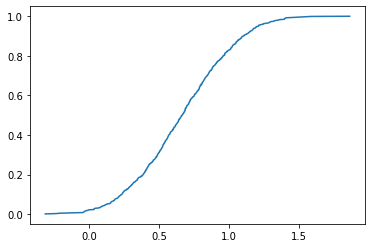

In [42]:
def cohen_effect(pair1, pair2):
    """ Calculate the Cohen effect size (pairs are mu, sigma )"""
    [mu1, sigma1] = pair1
    [mu2, sigma2] = pair2
    return (mu1 - mu2) / ((sigma1 + sigma2) / 2)

ds = []
for pair1, pair2 in zip(sample_treated, sample_control):
    d = cohen_effect(pair1, pair2)
    ds.append(d)
    
cdf = Cdf.from_seq(ds)
cdf.plot()
    

In [43]:
cdf.mean()

0.6661488072282833

In [44]:
cdf.credible_interval(0.9)

array([0.1254902, 1.2097561])

### Exercise 13-3
> Inspired by a question asked on Reddit.
>
> An instructor announces the results of an exam like this: "The average score was 81. Out of 25 students, 5 got more than 90 and no one failed (got less than 60)." Based on this, what do you think the standard deviation was?
> 
> You can assume that the distribtion of scores is approximately normal. For simplicity, assume that the sample mean 81 is actually the population mean, so we only have to estimate sigma.
>
> Hint: to compute the probability of a score greater than 90, use norm.sf, which computes the survival function ($1 - Cdf(x)$)

### Solution 13-3

In [45]:
hypos = np.linspace(1, 51, 101)

from scipy.stats import norm

# calculating the probability of getting gt 90% given the variances
pgt90 = norm(81, hypos).sf(90)
pgt90.shape

(101,)

In [46]:
from scipy.stats import binom

# probability that 5 of the 25 got greater than 90
likelihood1 = binom(25, pgt90).pmf(5)
likelihood1.shape

(101,)

In [52]:
# first update
prior = Pmf(1, hypos)
posterior1 = prior * likelihood1
posterior1.normalize()

5.299480018256258

<AxesSubplot:>

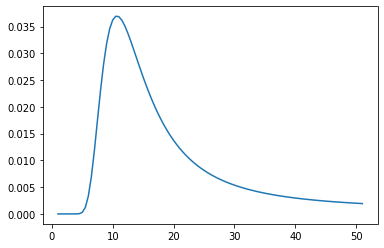

In [48]:
posterior1.plot()

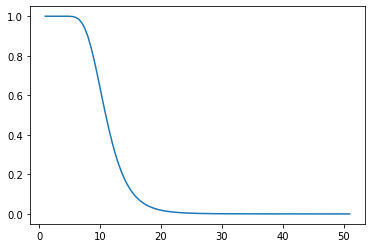

In [49]:
# Now for the second piece of information - that no one failed
pgt60 = norm(81, hypos).sf(60) # probability greater that 60
likelihood2 = pgt60 ** 25 # probability that all 25 got greater than 60
plt.plot(hypos, likelihood2)

In [50]:
prior = Pmf(1, hypos)
prior.normalize()
posterior2 = prior * likelihood1 * likelihood2
posterior2.normalize()

0.01425455531129565

<AxesSubplot:>

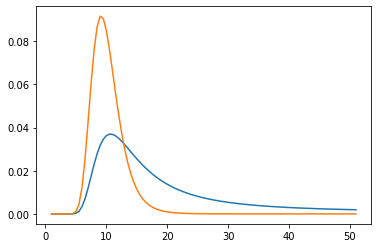

In [53]:
posterior1.plot()
posterior2.plot()

In [54]:
posterior2.mean()

10.189707962198526

In [55]:
posterior2.credible_interval(0.9)

array([ 7., 15.])

### Exercise 13-4
> The Variability Hypothesis is the observation that many physical traits are more variable among males than among females.
>
> Let's look at te distribution for heights of men and women in the US to see who is more variable.
>
> I used 2018 data from the CDC's Behavioural Risk Factor Surveillance System (BRFSS), which includes self-reported heights from 154,407 men and 254,722 women.
>
> Results:
> - The average height for men is 178cm; for women it is 163cm.
> - For men, the standard deviation is 8.27cm; for women, 7.75.
>
> However, these are in absolute terms. It is more meaningful to compute the coefficient of variation, (CV), which is the standard deviation divided by the mean. It is a dimensionless measure of variability relative to scale.
>
> For men, CV is 00465; for women, 0.0475. The coefficient of variation is higher for women, which would seem to be evidence against the variability hypothesis. But we can use Bayesian statistics to make this more precise. 
>
> Use these summary statistics to compute the posterior distribution of mu and sigma for the distributions of male and female height. Use Pmf.div_dist to compute posterior distribtions of CV. Based on this dataset and the assumption that the distribution of heights is normal, what is the probability the the coefficient of variation is higher for men? What is the most likely ratio of the CVs and what is the 90% credible interval?

In [56]:
def get_posterior_cv(joint):
    """ 
    Get the posterior distribution of CV 
    
    joint: joint distribution of mu, sigma
    
    returns: the smoothed posterior distribution
    """
    pmf_mu = marginal(joint, 0)
    pmf_sigma = marginal(joint, 1)
    pmf_cv = Pmf.div_dist(pmf_sigma, pmf_mu)
    return kde_from_pmf(pmf_cv)

In [57]:
n = 154407
mean = 178
std = 8.27

In [58]:
qs = np.linspace(mean - 0.1, mean + 0.1, 101)
prior_mu = make_uniform(qs, name='mean')

qs = np.linspace(std - 0.1, std + 0.1, 101)
prior_sigma = make_uniform(qs, name='std')

prior = make_joint(prior_mu, prior_sigma)

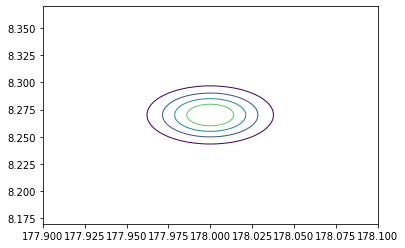

In [59]:
data = n, mean, std
posterior_male = update_norm_summary(prior, data)
plot_contour(posterior_male, cmap="blues")

In [60]:
n = 254722
mean = 163
std = 7.75

qs = np.linspace(mean - 0.1, mean + 0.1, 101)
prior_mu = make_uniform(qs, name="mean")

qs = np.linspace(std - 0.1, std + 0.1, 101)
prior_sigma = make_uniform(qs, name="std")

prior = make_joint(prior_mu, prior_sigma)

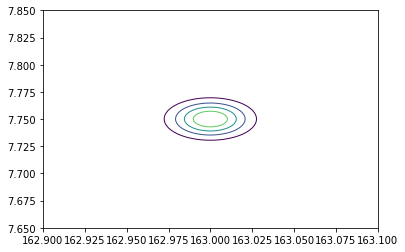

In [63]:
data = n, mean, std
posterior_female = update_norm_summary(prior, data)
plot_contour(posterior_female, cmap="Oranges")

<AxesSubplot:>

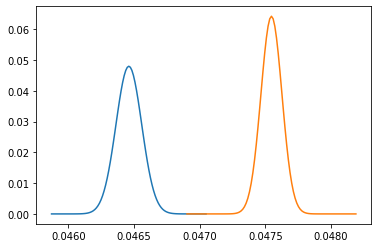

In [64]:
pmf_cv_male = get_posterior_cv(posterior_male)
kde_from_pmf(pmf_cv_male).plot()

pmf_cv_female = get_posterior_cv(posterior_female)
kde_from_pmf(pmf_cv_female).plot()

In [65]:
ratio_cv = Pmf.div_dist(pmf_cv_female, pmf_cv_male)
ratio_cv.max_prob()

1.0233615721208176

In [66]:
ratio_cv.credible_interval(0.9)

array([1.0193799 , 1.02734473])